In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance

df = pd.read_csv("../dataset/cleanedData.csv")

In [2]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

ttp pake smote

In [3]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\USER\App

In [4]:
#hyperparameter tuning
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid = GridSearchCV(
    xgb, param_grid,
    cv=3, scoring="roc_auc", n_jobs=-1, verbose=2
)

grid.fit(X_train_res, y_train_res)

print("best parameters:", grid.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:54:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [5]:
#evaluate latest model
best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]

print("improved xgb")
print("accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


improved xgb
accuracy: 0.767349260523322
ROC-AUC: 0.8121934592475997
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1291
           1       0.56      0.56      0.56       467

    accuracy                           0.77      1758
   macro avg       0.70      0.70      0.70      1758
weighted avg       0.77      0.77      0.77      1758



<Figure size 1000x600 with 0 Axes>

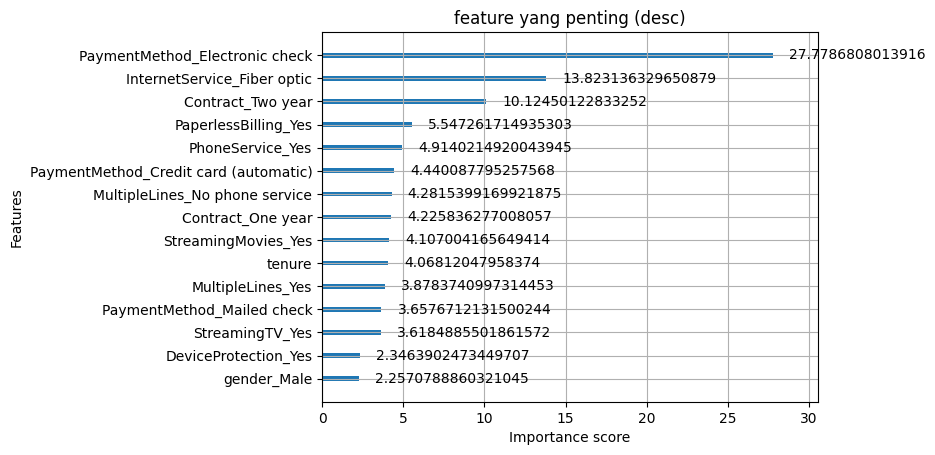

In [6]:
plt.figure(figsize=(10,6))
plot_importance(best_xgb, max_num_features=15, importance_type="gain")
plt.title("feature yang penting (desc)")
plt.show()

In [7]:
results = {
    "Model": ["baseline", "improved"],
    "accuracy": [0.77, accuracy_score(y_test, y_pred)],
    "ROC-AUC": [0.812, roc_auc_score(y_test, y_proba)],
    "recall (churn=1)": [0.50, classification_report(y_test, y_pred, output_dict=True)["1"]["recall"]],
    "precision (churn=1)": [0.58, classification_report(y_test, y_pred, output_dict=True)["1"]["precision"]],
    "f1-scoer (churn=1)": [0.54, classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"]]
}

df_results = pd.DataFrame(results)
print("\nsummary")
print(df_results)


summary
      Model  accuracy   ROC-AUC  recall (churn=1)  precision (churn=1)  \
0  baseline  0.770000  0.812000          0.500000             0.580000   
1  improved  0.767349  0.812193          0.561028             0.562232   

   f1-scoer (churn=1)  
0            0.540000  
1            0.561629  
